# AIM: develop the pretext task with EEGNet

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Pretext model & components:

### EEGNet:

In [2]:
# create Conv2d with max norm constraint
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm: int = 1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)
    
class EEGNet(nn.Module):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self,
                 chunk_size: int = 1244, # number of data points in each EEG chunk
                 num_electrodes: int = 26, # number of EEG electrodes
                 F1: int = 8, # number of filters in first convolutional layer
                 F2: int = 16, # number of filters in second convolutional layer
                 D: int = 2, # depth multiplier
                 num_extracted_features: int = 100, # number of features to extract  ## QUESTION
                 kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                 kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                 dropout: float = 0.25): # dropout rate
        super(EEGNet, self).__init__()
        self.F1 = F1
        self.F2 = F2
        self.D = D
        self.chunk_size = chunk_size
        self.num_extracted_features = num_extracted_features
        self.num_electrodes = num_electrodes
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.dropout = dropout

        self.block1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(self.F1,
                                 self.F1 * self.D, (self.num_electrodes, 1),
                                 max_norm=1,
                                 stride=1,
                                 padding=(0, 0),
                                 groups=self.F1,
                                 bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

        self.block2 = nn.Sequential(
            nn.Conv2d(self.F1 * self.D,
                      self.F1 * self.D, (1, self.kernel_2),
                      stride=1,
                      padding=(0, self.kernel_2 // 2),
                      bias=False,
                      groups=self.F1 * self.D),
            nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
            nn.Dropout(p=dropout))

        self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


    def feature_dim(self):
        # function to calculate the number of features after the convolutional blocks
        with torch.no_grad():
            mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

            mock_eeg = self.block1(mock_eeg)
            mock_eeg = self.block2(mock_eeg)

        return self.F2 * mock_eeg.shape[3]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.lin(x)
        return x

### pretext model:

In [20]:
class PretextModel(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self, num_extracted_features=100, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
        super(PretextModel, self).__init__()
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        # feature extractors
        self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
        
        # linear discriminate layer
        self.linear = nn.Linear(num_extracted_features, 1)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
        x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
        x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
        z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
        x = self.linear(z) # forward pass through linear layer
        return x
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y = train_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y = val_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch[0]
        y = test_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x = batch[0]
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
        return optimizer
    


## Pretext task

#### Functions & Classes

In [3]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


# function to sample two epochs and assign a label depending on whether the epochs are adjacent or not
def sample_two_epochs(epochs):
    if random.random() > 0.5: # decide whether to sample two adjacent epochs or two seperated epochs
        label = 1
        sample_idx = random.randint(0, len(epochs)-2) # -2 to prevent sampling the last epoch
        sample_idxs = [sample_idx, sample_idx+1]
    else:
        label = 0
        sample_idx = random.randint(0, len(epochs)-1)
        sample_idxs = [sample_idx, random.choice([i for i in range(len(epochs)) if i not in [sample_idx - 1, sample_idx, sample_idx + 1]])] 
    sampled_epochs = epochs[sample_idxs]
    # print(sampled_epochs.shape)
    return sampled_epochs, label

In [5]:
# function to create a dataset with EEG data
## CREATED WITH HELP OF GITHUB COPILOT
class SimpleRPDataset(torch.utils.data.Dataset):
    def __init__(self, preprocessed_dir, participant_ids):
        self.filepaths = [os.path.join(preprocessed_dir, f"{participant_id}.pt") for participant_id in participant_ids]
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        epochs = torch.load(self.filepaths[idx])
        sampled_epochs, label = sample_two_epochs(epochs)
        return sampled_epochs, label

In [7]:
class RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu'):
        """
        Dataset for the Relative Positioning task. Obtains all combinations of two epochs per participant.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.sampled_epochs_indices_id = []
        self.labels = []
        self.data_cache = {}
        self._load_data()

    def _load_data(self):
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
            # Generate all combinations of two epochs for this participant
            self.sample_all_combinations(participant_id, len(data))

    def sample_all_combinations(self, participant_id, num_epochs):
        """
        Sample all combinations of two epochs for a participant
        """
        all_combinations = list(itertools.combinations(range(num_epochs), 2))
        labels = [1 if abs(i - j) <= self.tpos else 0 for i, j in all_combinations]

        if self.subsample:
            # Subsample the combinations and labels
            sampled_indices = self.subsample_combinations(labels)
        else:
            # Use all combinations
            sampled_indices = range(len(all_combinations))

        # Store the combinations and labels
        for idx in sampled_indices:
            i, j = all_combinations[idx]
            label = labels[idx]
            self.sampled_epochs_indices_id.append((participant_id, i, j, label))
            self.labels.append(label)

    def subsample_combinations(self, labels):
        """
        Subsamples the combinations to ensure class balance
        """
        # Identify indices of samples with labels 0 and 1
        indices_0 = [idx for idx, label in enumerate(labels) if label == 0]
        indices_1 = [idx for idx, label in enumerate(labels) if label == 1]

        # Determine the smaller count between the two labels
        min_count = min(len(indices_0), len(indices_1))

        # Randomly sample indices from both labels to ensure they have the same count
        np.random.seed(42)  # For reproducibility
        sampled_indices_0 = np.random.choice(indices_0, min_count, replace=False)
        sampled_indices_1 = np.random.choice(indices_1, min_count, replace=False)

        # Combine the sampled indices
        sampled_indices = np.concatenate((sampled_indices_0, sampled_indices_1))
        return sampled_indices

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id, i, j, label = self.sampled_epochs_indices_id[idx]
        data = self.data_cache[participant_id]
        sampled_epochs = data[[i, j]]
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label, participant_id

#### Data loading & splitting

In [7]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
dataset = RPDataset(participant_ids, data_path, subsample=True, device='cuda')

print(np.unique(dataset.labels, return_counts=True))
print(len(dataset))
print(dataset[0][0].shape)

(array([0, 1]), array([13690, 13690], dtype=int64))
27380
torch.Size([2, 26, 1244])


In [8]:
# First obtain indices of the train/val/test sets to limit code rerun time
# obtain indices of the replication set in dataset as test set (participants starting with 'sub-19')
replication_indices = [idx for idx, sample in enumerate(dataset.sampled_epochs_indices_id) if sample[0].startswith('sub-19')]
# obtain the rest of the indices as train and validation set
trainval_indices = [idx for idx in range(len(dataset)) if idx not in replication_indices]

labels = [dataset.labels[idx] for idx in trainval_indices]
groups = [dataset.sampled_epochs_indices_id[idx][0] for idx in trainval_indices]

# stratified group kfold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)
np.save('data_test_indices.npy', replication_indices)

In [9]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')
data_test_indices = np.load('data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
train_labels = [dataset.labels[i] for i in data_train_indices]
val_labels = [dataset.labels[i] for i in data_val_indices]
test_labels = [dataset.labels[i] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 20038, Val: 5010, Test: 2332
Train: (array([0, 1]), array([10019, 10019], dtype=int64))
Val: (array([0, 1]), array([2505, 2505], dtype=int64))
Test: (array([0, 1]), array([1166, 1166], dtype=int64))


#### Training pretext model

In [10]:
# train pretext model
logger = CSVLogger("logs", name="pretext_task") # log results to csv file
torch.set_float32_matmul_precision('high') # for use of tensor cores
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = PretextModel()
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=100,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=100, shuffle=False, drop_last=False)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 100. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [10]:
# profile training
from lightning.pytorch.profilers import PyTorchProfiler
profiler = PyTorchProfiler(
    on_trace_ready=torch.profiler.tensorboard_trace_handler("logs/profiler0"),
    trace_memory=True,
    schedule=torch.profiler.schedule(wait=1, warmup=1, active=5)
)
logger = CSVLogger("logs", name="pretext_task") # log results to csv file
torch.set_float32_matmul_precision('high') # for use of tensor cores
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model1 = PretextModel()
trainer = Trainer(
    profiler=profiler,
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=1,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=100, shuffle=False, drop_last=False)

trainer.fit(model1, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

In [11]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'overtrained_pretext_model_weights.pt')


### plotting model diagnostics

In [13]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_1\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

100 100 100 100


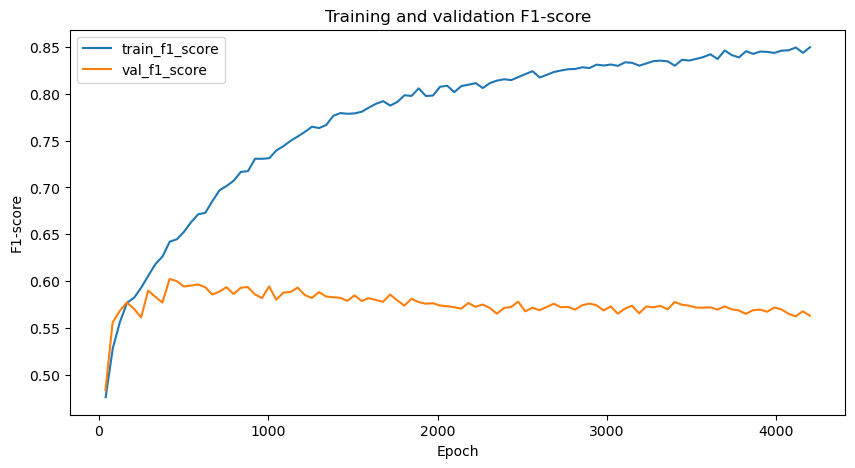

In [14]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Steps')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


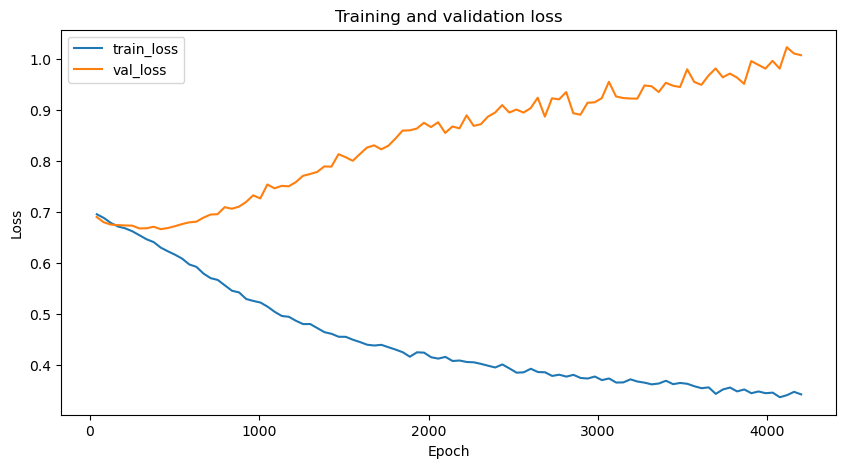

In [15]:
# plot training and validation loss  ## QUESTION
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


logs\pretext_task\version_1\checkpoints\epoch=9-train_loss=0.63-train_f1=0.64-val_loss=0.67-val_f1=0.60.ckpt


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2332. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.6119004487991333     │
│         test_loss         │    0.6539347767829895     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


classification report:
               precision    recall  f1-score   support

   separated       0.61      0.62      0.61      1166
    adjacent       0.61      0.60      0.61      1166

    accuracy                           0.61      2332
   macro avg       0.61      0.61      0.61      2332
weighted avg       0.61      0.61      0.61      2332

F1-score:
 0.6119004732494964
Accuracy:
 0.6119210977701544


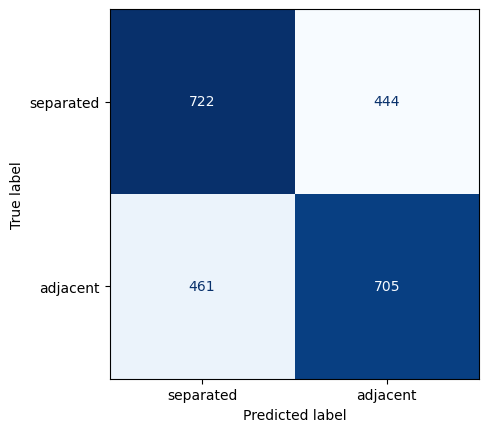

In [16]:
# load best model from checkpoint
model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_path)

# obtain predictions on test set and plot confusion matrix
test_loader = DataLoader(data_test, batch_size=len(data_test), shuffle=False,
                            drop_last=True)

# model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
trainer.test(model, test_loader)

# compute confusion matrix and classification report with sklearn of best model checkpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = trainer.predict(model, test_loader)
y_pred = np.concatenate(y_pred).flatten()
y = test_labels

class_labels = ['separated', 'adjacent']
print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
print('F1-score:\n', f1_score(y, y_pred, average="macro"))
print('Accuracy:\n', (y == y_pred).sum() / len(y))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
plt.grid(False)


In [17]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'pretext_model_weights.pt')


## Pretext model with weight decay and 0.5 dropout

#### Training pretext model

In [10]:
# train pretext model
logger = CSVLogger("logs", name="pretext_task") # log results to csv file
torch.set_float32_matmul_precision('high') # for use of tensor cores
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = PretextModel(dropout=0.5, weight_decay=0.01)
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=300,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=100, shuffle=False, drop_last=False)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 100. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 10. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [11]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'overtrained_pretext_model_2_b_weights.pt')


### plotting model diagnostics

In [12]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_3\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

300 300 300 300


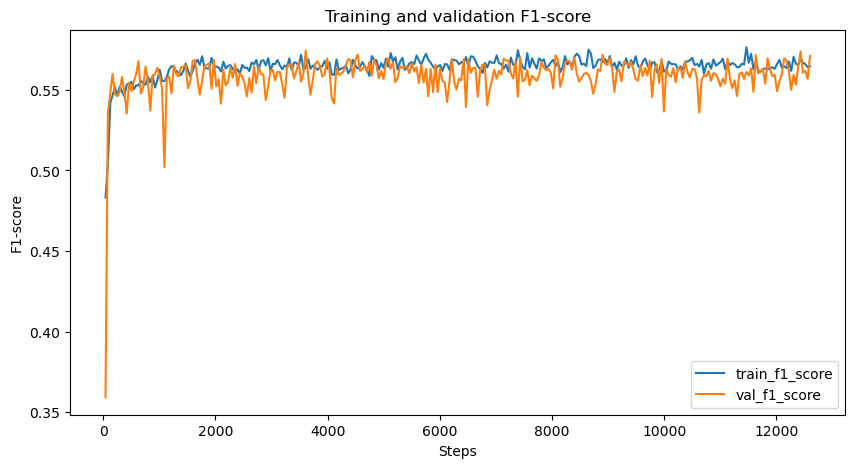

In [13]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Steps')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


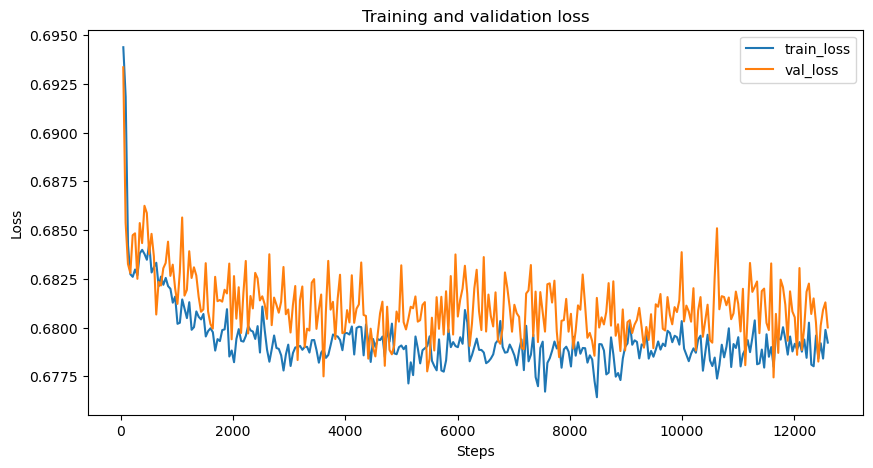

In [14]:
# plot training and validation loss  ## QUESTION
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


logs\pretext_task\version_3\checkpoints\epoch=85-train_loss=0.68-train_f1=0.56-val_loss=0.68-val_f1=0.57.ckpt


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2332. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.5655110478401184     │
│         test_loss         │    0.6793239116668701     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


classification report:
               precision    recall  f1-score   support

   separated       0.57      0.55      0.56      1166
    adjacent       0.56      0.58      0.57      1166

    accuracy                           0.57      2332
   macro avg       0.57      0.57      0.57      2332
weighted avg       0.57      0.57      0.57      2332

F1-score:
 0.5655110475466337
Accuracy:
 0.5656089193825042


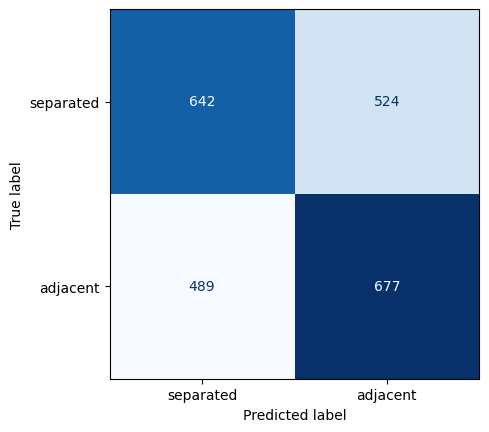

In [15]:
# load best model from checkpoint
model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_path)

# obtain predictions on test set and plot confusion matrix
test_loader = DataLoader(data_test, batch_size=len(data_test), shuffle=False,
                            drop_last=True)

# model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
trainer.test(model, test_loader)

# compute confusion matrix and classification report with sklearn of best model checkpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = trainer.predict(model, test_loader)
y_pred = np.concatenate(y_pred).flatten()
y = test_labels

class_labels = ['separated', 'adjacent']
print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
print('F1-score:\n', f1_score(y, y_pred, average="macro"))
print('Accuracy:\n', (y == y_pred).sum() / len(y))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
plt.grid(False)


In [16]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'pretext_model_2_b_weights.pt')


## Pretext model with higher tpos

In [8]:
# loading RP epochs with higher tpos
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
dataset = RPDataset(participant_ids, data_path, subsample=True, device='cuda', tpos=2)

print(np.unique(dataset.labels, return_counts=True))
print(len(dataset))
print(dataset[0][0].shape)

(array([0, 1]), array([12446, 12446], dtype=int64))
24892
torch.Size([2, 26, 1244])


In [10]:
# First obtain indices of the train/val/test sets to limit code rerun time
# obtain indices of the replication set in dataset as test set (participants starting with 'sub-19')
replication_indices = [idx for idx, sample in enumerate(dataset.sampled_epochs_indices_id) if sample[0].startswith('sub-19')]
# obtain the rest of the indices as train and validation set
trainval_indices = [idx for idx in range(len(dataset)) if idx not in replication_indices]

labels = [dataset.labels[idx] for idx in trainval_indices]
groups = [dataset.sampled_epochs_indices_id[idx][0] for idx in trainval_indices]

# stratified group kfold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save(r'DataScience_Thesis\data\splits\data_train_indices.npy', train_indices)
np.save(r'DataScience_Thesis\data\splits\data_val_indices.npy', val_indices)
np.save(r'DataScience_Thesis\data\splits\data_test_indices.npy', replication_indices)

In [11]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load(r'DataScience_Thesis\data\splits\data_train_indices.npy')
data_val_indices = np.load(r'DataScience_Thesis\data\splits\data_val_indices.npy')
data_test_indices = np.load(r'DataScience_Thesis\data\splits\data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
train_labels = [dataset.labels[i] for i in data_train_indices]
val_labels = [dataset.labels[i] for i in data_val_indices]
test_labels = [dataset.labels[i] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 18218, Val: 4554, Test: 2120
Train: (array([0, 1]), array([9109, 9109], dtype=int64))
Val: (array([0, 1]), array([2277, 2277], dtype=int64))
Test: (array([0, 1]), array([1060, 1060], dtype=int64))


#### Training pretext model

In [34]:
# train pretext model
logger = CSVLogger("logs", name="pretext_task") # log results to csv file
torch.set_float32_matmul_precision('high') # for use of tensor cores
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = PretextModel(dropout=0.5, learning_rate=1e-5, weight_decay=0.01)
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=300,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)

train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=100, shuffle=False, drop_last=False)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [35]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'overtrained_pretext_model_tpos2_weights.pt')


### plotting model diagnostics

In [36]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_10\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

300 300 300 300


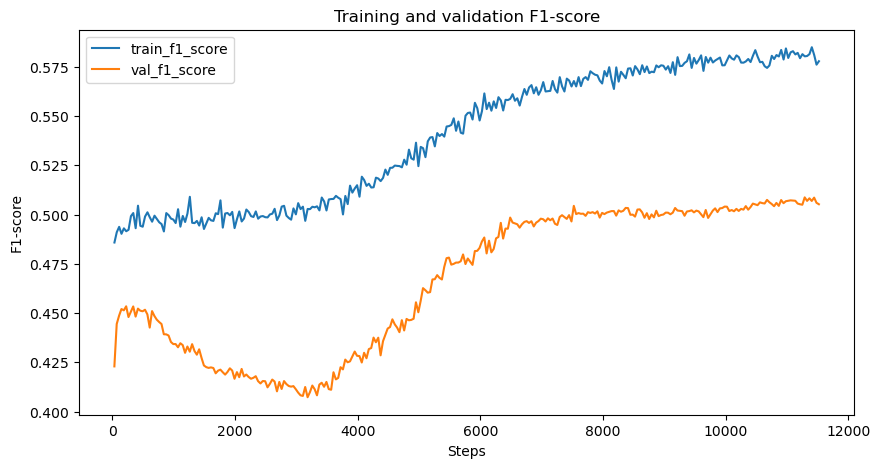

In [37]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Steps')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


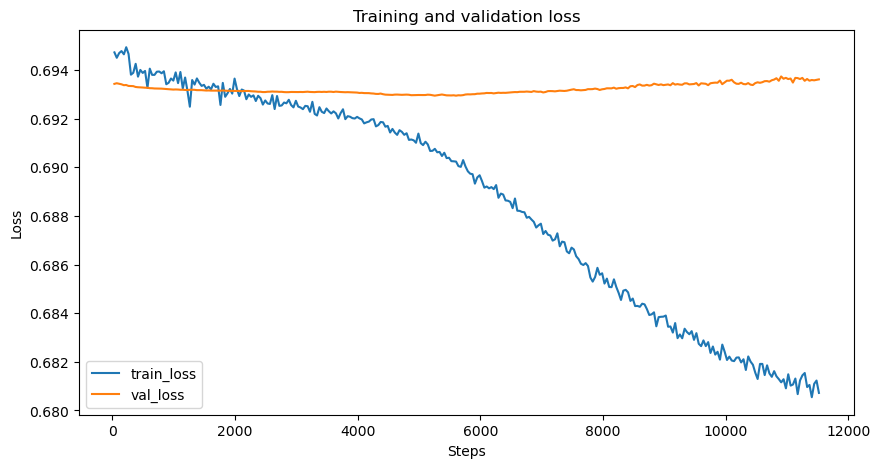

In [38]:
# plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


logs\pretext_task\version_10\checkpoints\epoch=293-train_loss=0.68-train_f1=0.58-val_loss=0.69-val_f1=0.51.ckpt


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │     0.511367678642273     │
│         test_loss         │     0.692936360836029     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


classification report:
               precision    recall  f1-score   support

   separated       0.52      0.44      0.47      1060
    adjacent       0.51      0.59      0.55      1060

    accuracy                           0.51      2120
   macro avg       0.51      0.51      0.51      2120
weighted avg       0.51      0.51      0.51      2120

F1-score:
 0.5113677049767276
Accuracy:
 0.5141509433962265


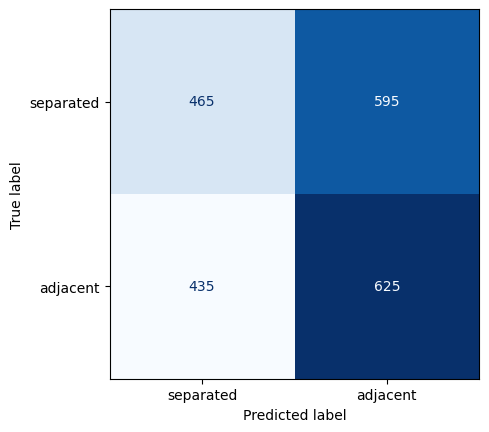

In [39]:
# load best model from checkpoint
model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_path)

# obtain predictions on test set and plot confusion matrix
test_loader = DataLoader(data_test, batch_size=len(data_test), shuffle=False,
                            drop_last=True)

# model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
trainer.test(model, test_loader)

# compute confusion matrix and classification report with sklearn of best model checkpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = trainer.predict(model, test_loader)
y_pred = np.concatenate(y_pred).flatten()
y = test_labels

class_labels = ['separated', 'adjacent']
print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
print('F1-score:\n', f1_score(y, y_pred, average="macro"))
print('Accuracy:\n', (y == y_pred).sum() / len(y))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
plt.grid(False)


In [40]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'pretext_model_tpos2_weights.pt')


## Soft Margin Loss

In [12]:
class PretextModel(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self, num_extracted_features=100, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
        super(PretextModel, self).__init__()
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        # feature extractors
        self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
        
        # linear discriminate layer
        self.linear = nn.Linear(num_extracted_features, 1)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
        x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
        x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
        z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
        x = self.linear(z) # forward pass through linear layer
        return x
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y = train_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y = val_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch[0]
        y = test_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x = batch[0]
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
        return optimizer
    


In [5]:
class RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu'):
        """
        Dataset for the Relative Positioning task. Obtains all combinations of two epochs per participant.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.sampled_epochs_indices_id = []
        self.labels = []
        self.data_cache = {}
        self._load_data()

    def _load_data(self):
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
            # Generate all combinations of two epochs for this participant
            self.sample_all_combinations(participant_id, len(data))

    def sample_all_combinations(self, participant_id, num_epochs):
        """
        Sample all combinations of two epochs for a participant
        """
        all_combinations = list(itertools.combinations(range(num_epochs), 2))
        labels = [1 if abs(i - j) == self.tpos else -1 for i, j in all_combinations]

        if self.subsample:
            # Subsample the combinations and labels
            sampled_indices = self.subsample_combinations(labels)
        else:
            # Use all combinations
            sampled_indices = range(len(all_combinations))

        # Store the combinations and labels
        for idx in sampled_indices:
            i, j = all_combinations[idx]
            label = labels[idx]
            self.sampled_epochs_indices_id.append((participant_id, i, j, label))
            self.labels.append(label)

    def subsample_combinations(self, labels):
        """
        Subsamples the combinations to ensure class balance
        """
        # Identify indices of samples with labels 0 and 1
        indices_0 = [idx for idx, label in enumerate(labels) if label == -1]
        indices_1 = [idx for idx, label in enumerate(labels) if label == 1]

        # Determine the smaller count between the two labels
        min_count = min(len(indices_0), len(indices_1))

        # Randomly sample indices from both labels to ensure they have the same count
        np.random.seed(42)  # For reproducibility
        sampled_indices_0 = np.random.choice(indices_0, min_count, replace=False)
        sampled_indices_1 = np.random.choice(indices_1, min_count, replace=False)

        # Combine the sampled indices
        sampled_indices = np.concatenate((sampled_indices_0, sampled_indices_1))
        return sampled_indices

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        data = self.data_cache[participant_id]
        sampled_epochs = data[[i, j]]
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label, participant_id

#### Data loading & splitting

In [6]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
dataset = RPDataset(participant_ids, data_path, subsample=True, device='cuda')

print(np.unique(dataset.labels, return_counts=True))
print(len(dataset))
print(dataset[0][0].shape)

(array([-1,  1]), array([13690, 13690], dtype=int64))
27380
torch.Size([2, 26, 1244])


In [7]:
# First obtain indices of the train/val/test sets to limit code rerun time
# obtain indices of the replication set in dataset as test set (participants starting with 'sub-19')
replication_indices = [idx for idx, sample in enumerate(dataset.sampled_epochs_indices_id) if sample[0].startswith('sub-19')]
# obtain the rest of the indices as train and validation set
trainval_indices = [idx for idx in range(len(dataset)) if idx not in replication_indices]

labels = [dataset.labels[idx] for idx in trainval_indices]
groups = [dataset.sampled_epochs_indices_id[idx][0] for idx in trainval_indices]

# stratified group kfold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)
np.save('data_test_indices.npy', replication_indices)

In [8]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')
data_test_indices = np.load('data_test_indices.npy')

# Create subsets using the indices
data_train = Subset(dataset, data_train_indices)
data_val = Subset(dataset, data_val_indices)
data_test = Subset(dataset, data_test_indices)

# Print dataset sizes and label distributions
train_labels = [dataset.labels[i] for i in data_train_indices]
val_labels = [dataset.labels[i] for i in data_val_indices]
test_labels = [dataset.labels[i] for i in data_test_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(data_test)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_labels, return_counts=True)}")

Train: 20038, Val: 5010, Test: 2332
Train: (array([-1,  1]), array([10019, 10019], dtype=int64))
Val: (array([-1,  1]), array([2505, 2505], dtype=int64))
Test: (array([-1,  1]), array([1166, 1166], dtype=int64))


#### Training pretext model

In [33]:
# train pretext model
logger = CSVLogger("logs", name="pretext_task") # log results to csv file
torch.set_float32_matmul_precision('high') # for use of tensor cores
# Create checkpoint callback
checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

model = PretextModel(dropout=0.5, weight_decay=0.01, learning_rate=1e-5)
trainer = Trainer(
    precision='16-mixed',
    accelerator='gpu',
    devices=1,
    max_epochs=300,
    callbacks=checkpoint_callback,
    enable_progress_bar=True,
    enable_model_summary=True,
    enable_checkpointing=True,
    logger=logger,
    log_every_n_steps=5,
)


train_loader = DataLoader(data_train, batch_size=100, shuffle=True, drop_last=True)
val_loader = DataLoader(data_val, batch_size=100, shuffle=False, drop_last=False)

trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


In [34]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'overtrained_soft_margin_loss_pretext_model_weights.pt')


### plotting model diagnostics

In [35]:
# load metrics data
metrics = pd.read_csv(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\metrics.csv')
train_f1_epoch = metrics['train_f1_epoch'].dropna()
train_loss_epoch = metrics['train_loss_epoch'].dropna()
val_f1 = metrics['val_f1'].dropna()
val_loss = metrics['val_loss'].dropna()
print(len(train_f1_epoch), len(train_loss_epoch), len(val_f1), len(val_loss))

300 300 300 300


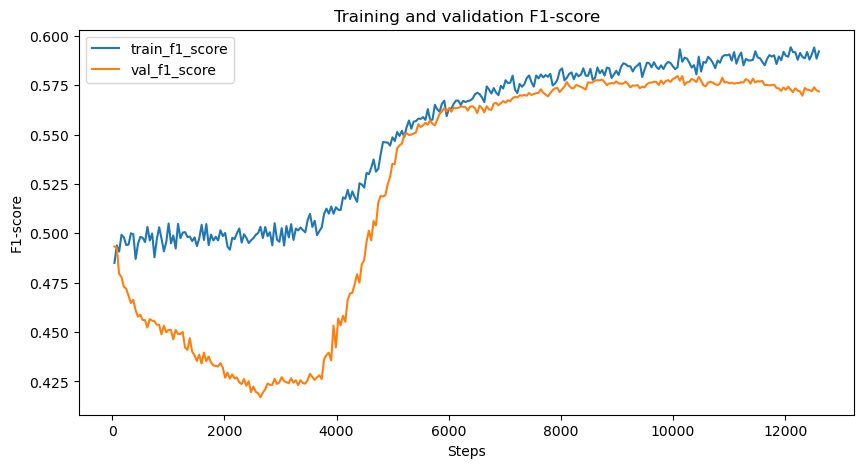

In [36]:
# plot training and validation f1-score
plt.figure(figsize=(10, 5))
plt.plot(train_f1_epoch, label='train_f1_score')
plt.plot(val_f1, label='val_f1_score')
plt.xlabel('Steps')
plt.ylabel('F1-score')
plt.legend()
plt.title('Training and validation F1-score')
plt.show()


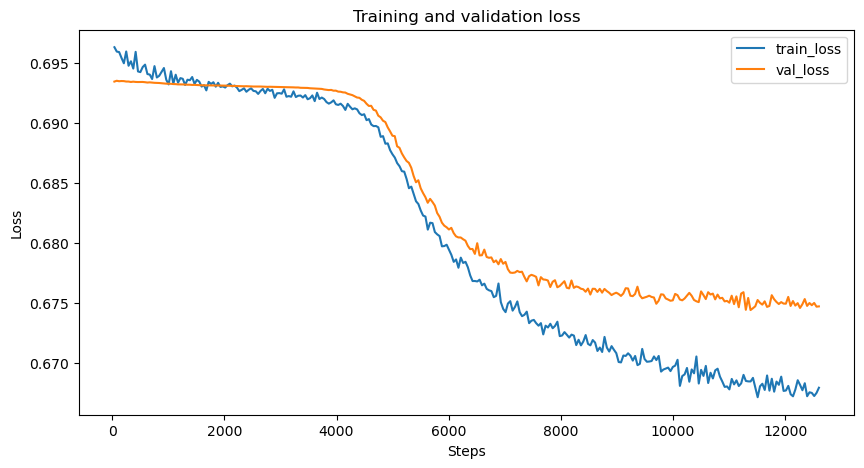

In [37]:
# plot training and validation loss  ## QUESTION
plt.figure(figsize=(10, 5))
plt.plot(train_loss_epoch, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and validation loss')
plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


logs\pretext_task\version_15\checkpoints\epoch=239-train_loss=0.67-train_f1=0.58-val_loss=0.68-val_f1=0.58.ckpt


c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.5869767665863037     │
│         test_loss         │    0.6716963648796082     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


classification report:
               precision    recall  f1-score   support

   separated       0.59      0.57      0.58      1166
    adjacent       0.58      0.60      0.59      1166

    accuracy                           0.59      2332
   macro avg       0.59      0.59      0.59      2332
weighted avg       0.59      0.59      0.59      2332

F1-score:
 0.5869767565041455
Accuracy:
 0.5870497427101201


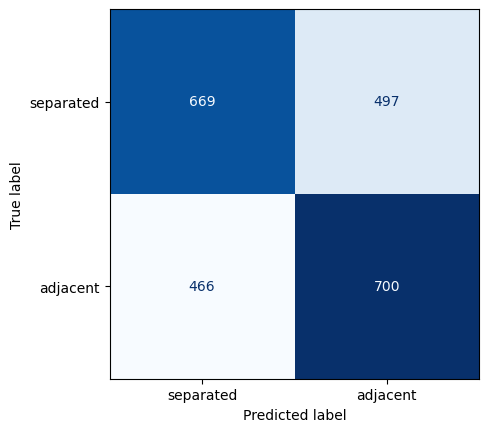

In [38]:
# load best model from checkpoint
model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_path)

# obtain predictions on test set and plot confusion matrix
test_loader = DataLoader(data_test, batch_size=len(data_test), shuffle=False,
                            drop_last=True)

# model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
trainer.test(model, test_loader)

# compute confusion matrix and classification report with sklearn of best model checkpoint
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = trainer.predict(model, test_loader)
y_pred = np.concatenate(y_pred).flatten()
y = np.array(test_labels)
y = np.where(y == -1, 0, y)

class_labels = ['separated', 'adjacent']
print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
print('F1-score:\n', f1_score(y, y_pred, average="macro"))
print('Accuracy:\n', (y == y_pred).sum() / len(y))
cm = confusion_matrix(y, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
plt.grid(False)


In [39]:
# store weights of pretext model to disk
pretrained_dict = model.state_dict()
torch.save(pretrained_dict, 'soft_margin_loss_pretext_model_weights.pt')
